In [2]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import numpy as np
import pandas as pd
#import pygeostat as gs
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import subprocess as sp
%pylab inline --no-import-all
from subprocess import check_output
# import tensorflow as tf
# from tensorflow.python import debug as tf_debug
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn import preprocessing
import scipy.spatial as scs
import scipy as sc
import math
from scipy.spatial import distance
from sklearn.metrics import mean_squared_error
import time
from sklearn.metrics import r2_score
from random import randrange
from IPython.display import clear_output
from scipy.ndimage import gaussian_filter
import h5py
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
# from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle
import random
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [5]:
import torch
import torchvision
import numpy as np
from torchvision import transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from tqdm import tqdm

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from transformers import ViTFeatureExtractor, ViTForImageClassification

In [7]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [8]:
# Set random seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

In [9]:

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get the current working directory
current_directory = os.getcwd()

# Construct the relative path to the train directory
train_data_dir = os.path.normpath(os.path.join(current_directory, '..', 'Dataset_3', 'train'))

# Create a DataLoader for the original training dataset (without applying transformations)
original_train_dataset = datasets.ImageFolder(train_data_dir)

# Calculate mean and std of every 10th sample of the original training dataset on the GPU
n = 1  # set n to the desired subsampling factor
mean_list = []
std_list = []
to_tensor = transforms.ToTensor()
for i, (data, target) in enumerate(original_train_dataset):
    if i % n == 0:
        data = to_tensor(data).unsqueeze(0)  # Convert to tensor and add an extra dimension for batch size
        data = data.to(device)
        mean_list.append(torch.mean(data, dim=(0, 2, 3)))
        std_list.append(torch.std(data, dim=(0, 2, 3)))

# Calculate the overall mean and std
mean = torch.mean(torch.stack(mean_list), dim=0)
std = torch.mean(torch.stack(std_list), dim=0)

# Move the mean and std tensors back to the CPU for printing
mean = mean.cpu().tolist()
std = std.cpu().tolist()

print('Mean:', mean)
print('Std:', std)

Mean: [0.3529130220413208, 0.3529130220413208, 0.3529130220413208]
Std: [0.15991665422916412, 0.15991665422916412, 0.15991665422916412]


In [10]:
# set device to CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# train and test data directory
train_data_dir = os.path.normpath(os.path.join(current_directory, '..', 'Dataset_3', 'train'))
val_data_dir = os.path.normpath(os.path.join(current_directory, '..', 'Dataset_3', 'val'))
test_data_dir = os.path.normpath(os.path.join(current_directory, '..', 'Dataset_3', 'test'))

# define transform to apply on the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,std=std),
    transforms.Resize((224,224),antialias=True),

])

train_dataset = torchvision.datasets.ImageFolder(train_data_dir, transform=transform)
val_dataset = torchvision.datasets.ImageFolder(val_data_dir, transform=transform)
test_dataset = torchvision.datasets.ImageFolder(test_data_dir, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [11]:
batch_size = 32

train_data=train_dataset
val_data =val_dataset
test_data=test_dataset

print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")
print(f"Length of Test Data : {len(test_data)}")


Length of Train Data : 560
Length of Validation Data : 372
Length of Test Data : 188


In [12]:
#torch.cuda.empty_cache()

In [13]:
# Function to calculate class distributions
def calculate_class_proportions(data_dir):
    dataset = datasets.ImageFolder(data_dir, transform=to_tensor)

    # Calculate class counts
    class_counts = np.bincount(dataset.targets)

    # Normalize class counts to obtain class proportions
    class_proportions = class_counts / np.sum(class_counts)

    return class_proportions

# Calculate class proportions for the train, validation, and test datasets
train_proportions = calculate_class_proportions(train_data_dir)
val_proportions = calculate_class_proportions(val_data_dir)
test_proportions = calculate_class_proportions(test_data_dir)

In [14]:
class_proportions = calculate_class_proportions(train_data_dir)
class_weights = 1.0 / class_proportions

In [14]:
from transformers import ViTModel

class AttentionFusion(nn.Module):
    def __init__(self, cnn_hidden_size, vit_hidden_size):
        super(AttentionFusion, self).__init__()
        self.cnn_hidden_size = cnn_hidden_size
        self.vit_hidden_size = vit_hidden_size
        self.attention_weights = nn.Parameter(torch.Tensor(cnn_hidden_size, vit_hidden_size))
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, cnn_features, vit_features):
        cnn_attention = torch.matmul(cnn_features.unsqueeze(1), self.attention_weights)
        attention_scores = torch.matmul(cnn_attention, vit_features.transpose(1, 2))
        attention_weights = self.softmax(attention_scores)
        fused_features = torch.matmul(attention_weights, vit_features)
        fused_features = fused_features.squeeze(1)
        return fused_features


class HybridModel(nn.Module):
    def __init__(self, cnn_backbone, vit_backbone, num_cnn_features, num_vit_features, num_classes):
        super(HybridModel, self).__init__()
        self.cnn_backbone = cnn_backbone
        self.vit_backbone = vit_backbone
        self.fusion = AttentionFusion(num_cnn_features, num_vit_features)
        self.fc = nn.Linear(num_vit_features, num_classes)

    def forward(self, x):
        cnn_features = self.cnn_backbone(x)
        vit_features = self.vit_backbone(x).last_hidden_state
        fused_features = self.fusion(cnn_features, vit_features)
        output = self.fc(fused_features)
        return output


# Create the CNN backbone
cnn_backbone = models.resnet50(pretrained=True)
cnn_backbone.fc = nn.Identity()  # Remove the last fully connected layer

# Create the ViT backbone
vit_backbone = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
num_vit_features = vit_backbone.config.hidden_size

# Define the hybrid model
num_classes = 4
model = HybridModel(cnn_backbone, vit_backbone, num_cnn_features=2048, num_vit_features=num_vit_features, num_classes=num_classes)

# Move the model to the desired device (e.g., GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)



# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=torch.Tensor(class_weights).to(device))
optimizer = optim.Adam(model.parameters(),lr=0.001,weight_decay=0.01)

# During evaluation, calculate class weights based on the class proportions in the validation set
val_class_weights = 1.0 / val_proportions
# Define the loss function for weighted evaluation
eval_criterion = nn.CrossEntropyLoss(weight=torch.Tensor(val_class_weights).to(device))


# initialize best validation loss to infinity
best_val_loss = float('inf')
best_train_loss = float('inf')
best_diff=float('inf')
val_loss_temp=float('inf')
ep=0

train_losses = []
val_losses = []
epoch_values = []


# train the model
num_epochs = 10

start_time = time.time()  # Start time

for epoch in range(num_epochs):
    train_loss = 0.0
    train_accuracy = 0.0  # Variable to store training accuracy

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        # Calculate training accuracy
        _, preds = torch.max(outputs.data, 1)
        train_accuracy += torch.sum(preds == labels.data).item()

    # calculate average training loss and accuracy for the epoch
    train_loss /= len(train_loader)
    train_accuracy /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # evaluate the model on the validation set
    val_loss = 0.0
    val_accuracy = 0.0
    with torch.no_grad():
        model.eval()
        for images, labels in tqdm(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            val_loss += eval_criterion(outputs, labels).item()
            _, preds = torch.max(outputs.data, 1)
            val_accuracy += torch.sum(preds == labels.data).item()
        val_loss /= len(val_loader)
        val_accuracy /= len(val_loader.dataset)
        val_losses.append(val_loss)
        
    epoch_values.append(epoch + 1)

    print('Epoch [{}/{}], Training Loss: {:.4f}, Training Accuracy: {:.4f}, Validation Loss: {:.4f}, Validation Accuracy: {:.4f}'
          .format(epoch+1, num_epochs, train_loss, train_accuracy, val_loss, val_accuracy))
    
    diff= abs(train_loss-val_loss)

    # save the model if it achieves the best validation loss and train loss so far
    if (val_loss < best_val_loss and train_loss < best_train_loss) or (diff<=best_diff):
        if(val_loss<val_loss_temp):
            best_val_loss = val_loss
            best_train_loss = train_loss
            best_diff= diff
            torch.save(model.state_dict(), 'D3_Hybrid_pretrain_WB_AF.pth')
            print(f"Best model saved at epoch {epoch+1}")
            ep=epoch+1
            
    val_loss_temp=val_loss  
        
end_time = time.time()  # End time
total_time = end_time - start_time  # Total training time in seconds
total_time_minutes = total_time / 60  # Convert to minutes

# Save epoch values, train losses, and validation losses to a CSV file
data = np.array([epoch_values, train_losses, val_losses]).T
np.savetxt("losses_A_D3.csv", data, delimiter=",", header="Epoch,Train_Loss,Validation_Loss", comments="")

print('\n')
print(f"Total training time: {total_time:.4f} seconds")
print(f"Total training time: {total_time_minutes:.4f} minutes")
print(f"Final Best model saved at epoch {ep}")



100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:18<00:00,  1.54s/it]


Epoch [1/10], Training Loss: 0.8895, Training Accuracy: 0.6768, Validation Loss: 0.7362, Validation Accuracy: 0.7204
Best model saved at epoch 1


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:22<00:00,  1.87s/it]


Epoch [2/10], Training Loss: 0.8971, Training Accuracy: 0.6536, Validation Loss: 0.9522, Validation Accuracy: 0.6640


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:16<00:00,  1.38s/it]


Epoch [3/10], Training Loss: 0.9557, Training Accuracy: 0.6071, Validation Loss: 0.8160, Validation Accuracy: 0.7016
Best model saved at epoch 3


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:16<00:00,  1.36s/it]


Epoch [4/10], Training Loss: 0.8589, Training Accuracy: 0.6589, Validation Loss: 0.8698, Validation Accuracy: 0.6129


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:16<00:00,  1.41s/it]


Epoch [5/10], Training Loss: 0.6903, Training Accuracy: 0.7250, Validation Loss: 1.2279, Validation Accuracy: 0.5242


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:16<00:00,  1.41s/it]


Epoch [6/10], Training Loss: 0.7776, Training Accuracy: 0.6982, Validation Loss: 0.6775, Validation Accuracy: 0.7366
Best model saved at epoch 6


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:15<00:00,  1.33s/it]


Epoch [7/10], Training Loss: 0.7469, Training Accuracy: 0.7018, Validation Loss: 0.9304, Validation Accuracy: 0.5349


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.02it/s]


Epoch [8/10], Training Loss: 0.6833, Training Accuracy: 0.7304, Validation Loss: 0.7397, Validation Accuracy: 0.7151
Best model saved at epoch 8


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.60it/s]


Epoch [9/10], Training Loss: 0.8013, Training Accuracy: 0.6768, Validation Loss: 1.0635, Validation Accuracy: 0.5054


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.58it/s]

Epoch [10/10], Training Loss: 0.7138, Training Accuracy: 0.7179, Validation Loss: 0.7804, Validation Accuracy: 0.6640


Total training time: 727.9144 seconds
Total training time: 12.1319 minutes
Final Best model saved at epoch 8


In [15]:
data = np.loadtxt("losses_A_D3.csv", delimiter=",", skiprows=1)  # Skip the header
epoch_values = data[:, 0]
train_losses = data[:, 1]
val_losses = data[:, 2]

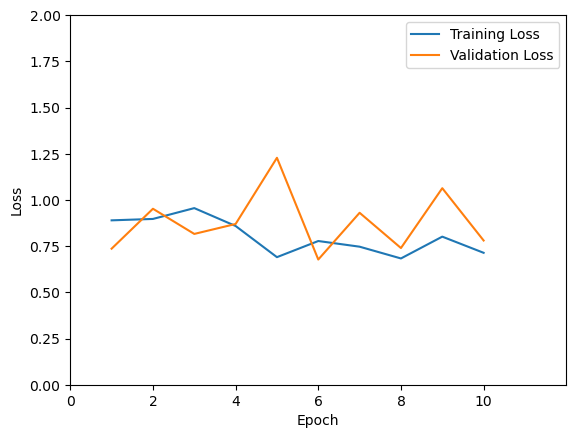

In [16]:
plt.plot(epoch_values, train_losses, label='Training Loss')
plt.plot(epoch_values, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.title('D3 ResNet50 Pretrained')
plt.xlim(0,12)
plt.ylim(0,2)
plt.xticks(range(0, 12, 2))
plt.legend()
plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
current_directory = os.getcwd()
# Define the filename
filename = "D3_Hybrid_Pretrained_EvsL_WB_AF.png"
# Construct the file path relative to the current directory
file_path = os.path.join(current_directory, filename)
plt.savefig(file_path)
plt.show()

In [17]:
from transformers import ViTForImageClassification

from transformers import ViTModel


from transformers import ViTModel


import torch
import torch.nn as nn
import torchvision.models as models
from transformers import ViTModel


class AttentionFusion(nn.Module):
    def __init__(self, cnn_hidden_size, vit_hidden_size):
        super(AttentionFusion, self).__init__()
        self.cnn_hidden_size = cnn_hidden_size
        self.vit_hidden_size = vit_hidden_size
        self.attention_weights = nn.Parameter(torch.Tensor(cnn_hidden_size, vit_hidden_size))
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, cnn_features, vit_features):
        cnn_attention = torch.matmul(cnn_features.unsqueeze(1), self.attention_weights)
        attention_scores = torch.matmul(cnn_attention, vit_features.transpose(1, 2))
        attention_weights = self.softmax(attention_scores)
        fused_features = torch.matmul(attention_weights, vit_features)
        fused_features = fused_features.squeeze(1)
        return fused_features


class HybridModel(nn.Module):
    def __init__(self, cnn_backbone, vit_backbone, num_cnn_features, num_vit_features, num_classes):
        super(HybridModel, self).__init__()
        self.cnn_backbone = cnn_backbone
        self.vit_backbone = vit_backbone
        self.fusion = AttentionFusion(num_cnn_features, num_vit_features)
        self.fc = nn.Linear(num_vit_features, num_classes)

    def forward(self, x):
        cnn_features = self.cnn_backbone(x)
        vit_features = self.vit_backbone(x).last_hidden_state
        fused_features = self.fusion(cnn_features, vit_features)
        output = self.fc(fused_features)
        return output


# Create the CNN backbone
cnn_backbone = models.resnet50(pretrained=True)
cnn_backbone.fc = nn.Identity()  # Remove the last fully connected layer

# Create the ViT backbone
vit_backbone = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
num_vit_features = vit_backbone.config.hidden_size

# Define the hybrid model
num_classes = 4

model = HybridModel(cnn_backbone, vit_backbone, num_cnn_features=2048, num_vit_features=num_vit_features, num_classes=num_classes)



# Load the saved model weights
model.load_state_dict(torch.load('D3_Hybrid_pretrain_WB_AF.pth'))



# Move the model to the desired device (e.g., GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
# Calculate class proportions for the test dataset
test_proportions = calculate_class_proportions(test_data_dir)

# Calculate class weights for evaluation
eval_class_weights = 1.0 / test_proportions

criterion_eval = nn.CrossEntropyLoss(weight=torch.Tensor(eval_class_weights).to(device))
optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=0.01)


In [18]:
from tqdm import tqdm
# evaluate the model on the test set with weighted evaluation
test_loss = 0.0
test_accuracy = 0.0
true_labels = []
predicted_labels = []

with torch.no_grad():
    model.eval()
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        model.to(device)  # Move the model to the same device as the input data
        outputs = model(images)
        test_loss += criterion_eval(outputs, labels).item()
        _, preds = torch.max(outputs.data, 1)
        test_accuracy += torch.sum(preds == labels.data).item()
        true_labels += labels.tolist()
        predicted_labels += preds.tolist()

test_loss /= len(test_loader)
test_accuracy /= len(test_loader.dataset)

print('Test Loss: {:.4f}, Test Accuracy: {:.4f}'.format(test_loss, test_accuracy))

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.89it/s]

Test Loss: 0.6893, Test Accuracy: 0.6809


In [19]:
del images, labels

In [26]:
print('Test accuracy obtained with Normalized Dataset 3 using AF Hybrid Model:',(test_accuracy*100),'%')

Test accuracy obtained with Normalized Dataset 3 using AF Hybrid Model: 68.08510638297872 %


In [21]:
class_names = ['3001_Breccia','3002_IHS','3003_Other','3004_Sand']
class_to_index = {class_name: index for index, class_name in enumerate(class_names)}

In [22]:
# Load the trained model
model_state_dict = torch.load('D3_Hybrid_pretrain_WB_AF.pth')

# Retrieve the class index to name mapping from the class_to_index dictionary
class_index_to_name = {index: class_name for class_name, index in class_to_index.items()}

In [23]:
# Create empty lists to store the class information
class_index_list = []
class_name_list = []
class_label_list = []

# Iterate over the class indices and retrieve the corresponding name and label
for i in range(model.fc.out_features):
    class_index = i
    class_name = class_index_to_name[class_index]
    class_label = class_name[:4]  # get the first 4 characters of the class name as label
    class_index_list.append(class_index)
    class_name_list.append(class_name)
    class_label_list.append(class_label)

# Print the class information
for i in range(len(class_index_list)):
    print(f"Class Index: {class_index_list[i]}, Class Name: {class_name_list[i]}, Class Label: {class_label_list[i]}")


Class Index: 0, Class Name: 3001_Breccia, Class Label: 3001
Class Index: 1, Class Name: 3002_IHS, Class Label: 3002
Class Index: 2, Class Name: 3003_Other, Class Label: 3003
Class Index: 3, Class Name: 3004_Sand, Class Label: 3004


[[47  1  1  2]
 [ 9 23  0 15]
 [27  0 12  1]
 [ 1  2  1 46]]


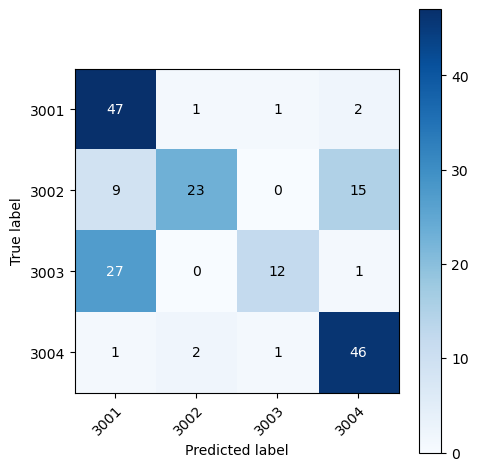

              precision    recall  f1-score   support

3001_Breccia       0.56      0.92      0.70        51
    3002_IHS       0.88      0.49      0.63        47
  3003_Other       0.86      0.30      0.44        40
   3004_Sand       0.72      0.92      0.81        50

    accuracy                           0.68       188
   macro avg       0.76      0.66      0.64       188
weighted avg       0.75      0.68      0.66       188



In [24]:
# plot confusion matrix


cm = confusion_matrix(true_labels, predicted_labels)
print(cm)
normalize = True
fig, ax = plt.subplots(figsize=(5,5)) # enlarge the plot
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=class_label_list, yticklabels=class_label_list,
       #title='D3 Hybrid Pretrained',
       ylabel='True label',
       xlabel='Predicted label')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
fmt = 'd' if not normalize else '.0f' # update format to print integers only
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()

current_directory = os.getcwd()
# Define the filename
filename = "D3 Hybrid Pretrained Conf WB AF.png"
# Construct the file path relative to the current directory
file_path = os.path.join(current_directory, filename)

plt.savefig(file_path)
plt.show()


# print classification report
print(classification_report(true_labels, predicted_labels, target_names=class_names))

In [25]:
torch.cuda.empty_cache()